In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0


# Week 5 : Introduction to Convolutional Neural Networks, Kaggle Competitions and Computer Vision Techniques

### Recap of Neural Networks

In this notebook, we examine the representation of neural networks and how they learn. We will build a neural network from scratch with just numpy, implementing both the forward and backward propagation. Our implementation will then be used to build and train a neural network model using the MNIST dataset.

Tensorflow will be intoduced in this notebook and will also be used to train a neural network on the MNIST dataset. We will check how well the model built with our implementation performs compared to that built with tensorflow.

Neural networks are represented by layers of neurons. There are three types of layers, namely;

- The input layer, 
- The hidden layers, 
- The output layer.


A network can have more than one hidden layers but can only have one input layer and one output layer. Each layer has a Weight matrix and bias vector. These are the network's parameters.  At the output layer, there is usually a loss function which serves as a check of model performace.

The figure below shows how a neural network is represented.
![alt_text](http://i67.tinypic.com/dlj42e.png" border="0" alt="Image and video hosting by TinyPic"></a>"CNN Architecture for MNIST Classification")

In the implementation that follows, a layer would be treated as an object and all layer parameters will become attributes of the layer object.

In [0]:
## I don't want warnings at all!!
import warnings
warnings.filterwarnings('ignore')


import numpy. For this part, we will use just numpy no framework is allowed. just numpy !

In [0]:
import numpy as np
import pdb


A Layer class to serve as the base class for all layer types.

In [0]:
# To build layers
class Layer(object):
  
  def __init__(self):
    self.init = False
    self.learnable_params = False
  
  def forward(self, x):
    pass
  
  def backward(self, d):
    pass
  
  def __call__(self, x):
    return self.forward(x)
  

Losses are usually calculated at the output layer. There are several loss functions. The class below serves as the base class for all loss functions.

In [0]:

# For loss functions  
class Loss(object):
  def __init__(self):
    pass
  
  def forward(self, z, y):
    pass
  
  def backward(self):
    pass
  
  def __call__(self, z, y):
    return self.forward(z, y)

Dense layers are used in vanilla neural networks. The layers in the figure above are all dense layers. They are called dense layers because for a layer, each neuron has a connection to all the neurons in the preceding layer.

In [0]:
class Dense(Layer):
  
  def __init__(self, units):
    super(Dense, self).__init__()
    self.nout = units # number of output units
    self.learnable_params = True
  
  def forward(self, x):
    self.nin = x.shape[0] # number of input units
    self.x = x # save the input to the layer
    
    
    # initialize weights only once
    if(not self.init):
      self.init = True
      self.W = np.random.normal(0, np.sqrt((2/(self.nin+self.nout))), (self.nout, self.nin)) # using xavier initialization
      self.b = np.zeros(self.nout).reshape(-1,1)
    
    # weighted sum
    z = self.W.dot(x) + self.b
    
    return z
  
  def backward(self, din):
    
    self.backprop = True
    
    #pdb.set_trace()
    self.dx = self.W.T.dot(din)
    self.dW = din.dot(self.x.T)
    self.db = din.sum(axis=1).reshape((-1,1))
    
    return self.dx
  
  def update(self, lr):
    
    if(self.backprop):
      self.W -= lr*self.dW
      self.b -= lr*self.db
    
    self.backprop = False

Activation functions can be seen as layers that just applies a function to its input. Here, we used the ReLU activation function. Other activation functions can also be implemented in this manner.

In [0]:
class Relu(Layer):
  
  def __init(self):
    super(Relu, self).__init__()
    
    
  def forward(self, x):
    self.x = x # save the layer's input
    a = np.maximum(x, 0) # relu function
    return a
  
  def backward(self, da):
    dx = ((self.x > 0)*1)*da
    
    return dx

Loss functions are very important in Neural Networks and to some extent, determine how the network learns. We will implement the softmax cross entropy loss. This implementation might look suspicious. Don't worry. Somethings have be included for numerical stability.

In [0]:
# For the softmax loss
class SoftmaxCrossEntropy(Loss):
  
  def __init__(self):
    super(SoftmaxCrossEntropy, self).__init__()
    
  def forward(self, z, y):
    self.logits = z # weighted sum (output layer)
    self.labels = y # true labels
    

    
    c = np.max(self.logits, axis=0).reshape((1,-1)) # get the maximum weighted sum
    scaled_z = self.logits - c # subtract the maximum from all
    
    logit_exp = np.exp(scaled_z) # e^z
    sum_exp = np.sum(logit_exp, axis=0).reshape((1,-1)) # sum(e^z)
    
    norm_probs = logit_exp / sum_exp # e^z/sum(e^z) = normalized probabilities
    
    self.t_logit = np.sum(self.labels*self.logits, axis=0).reshape((1,-1)) # the logit of the true class
    
    logsumexp = np.log(sum_exp) # to be used for logsumexp algorithm for softmax loss


    loss = -1*(self.t_logit - logsumexp - c) # logsumexp for loss
    
    self.probs = norm_probs # normalized probabilies saved
    
    return loss
  
  def backward(self):
    return self.probs - self.labels
  
  
  

Now, since everything needed to build the neural network is in place. We can now go ahead and build the Network.

In [0]:
class NeuralNetwork(object):
  
  def __init__(self, representation):
    
    self.l = representation
    self.layers = []
    self.loss = 0
    self.step = 0
    
    for l in range(1, len(self.l)-1):
      dense = Dense(self.l[l])
      activation = Relu()
      
      self.layers += [dense, activation]
    
    # output layer
    dense = Dense(self.l[-1])
    self.layers += [dense]
    
  
  # forward propagation
  def forward(self, x):
    
    for l in range(len(self.layers)):
      x = self.layers[l](x)
 
    self.z = x
    return x
  
  # backward propagation
  def backward(self, y):
    lossfunction = SoftmaxCrossEntropy() # loss function
    loss = lossfunction(self.z, y)
    dloss = lossfunction.backward()
    
    # go through all the layers starting from the output layer
    for l in range(1,len(self.layers)+1):
      #pdb.set_trace()
      dloss = self.layers[-l].backward(dloss)
      
    return loss
  
  def fit_one_step(self, x, y, BS, lr):
    self.forward(x)
    loss = self.backward(y)
    self.loss += np.sum(loss)
    self.step += BS
    # update layer weight
    for layer in self.layers:
      if layer.learnable_params:
        layer.update(lr)
        
        
  def epoch_loss(self):
    loss = self.loss/self.step
    self.loss = 0
    self.step = 0
    return loss
  
  def predict(self, x):
    z = self.forward(x)
    loss = SoftmaxCrossEntropy()
    loss.forward(z, np.zeros(z.shape))
    
    return loss.probs

Load  the MNIST dataset and train the model

In [0]:
import tensorflow as tf

In [0]:
mnist = tf.keras.datasets.mnist # get mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data() # extract train and test sets

In [0]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]
image_size = train_images.shape[1:]

print('There are {} train examples'.format(n_train))
print('There are {} test example'.format(n_test))
print('images are of size {}'.format(image_size))

There are 60000 train examples
There are 10000 test example
images are of size (28, 28)


Lets display a random train example

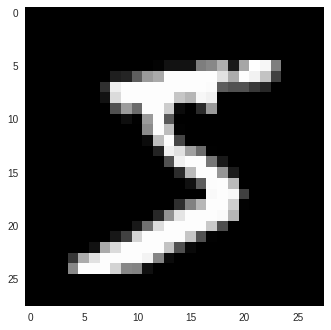

In [0]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0], cmap='gray')
plt.grid(False)

Lets normalize the data.


In [0]:
train_images = train_images / train_images.max()
test_images = test_images / train_images.max()

# reshape
no_inputs = np.prod(image_size)

train_images = train_images.reshape((-1, no_inputs))
test_images = test_images.reshape((-1, no_inputs))

In [0]:
myNN = NeuralNetwork([no_inputs, 20,10])

In [0]:
# train model
BS = 32
epochs = 10
no_steps = n_train//BS
for ii in range(epochs):
  for i in range(no_steps):
    x = train_images[i*BS:i*BS+BS]

    y = np.eye(10)[train_labels[i*BS:i*BS+BS]]
    
    myNN.fit_one_step(x.T,y.T,BS, 0.001)
  
  acc = (myNN.predict(train_images.T).argmax(axis=0) == np.int64(train_labels)).sum()/n_train
  testacc = (myNN.predict(test_images.T).argmax(axis=0) == np.int64(test_labels)).sum()/n_test
  print('epoch {}=> loss={} | train_accuracy: {} ; test_accuracy: {}'.format(ii,myNN.epoch_loss(), acc, testacc))

epoch 0=> loss=0.4723468768962434 | train_accuracy: 0.9093166666666667 ; test_accuracy: 0.9136
epoch 1=> loss=0.2687444523246783 | train_accuracy: 0.9243833333333333 ; test_accuracy: 0.9206
epoch 2=> loss=0.23418273868951398 | train_accuracy: 0.9322333333333334 ; test_accuracy: 0.9231
epoch 3=> loss=0.2116436811726788 | train_accuracy: 0.9376 ; test_accuracy: 0.9244
epoch 4=> loss=0.19425727188302142 | train_accuracy: 0.9425666666666667 ; test_accuracy: 0.927
epoch 5=> loss=0.18062778524174725 | train_accuracy: 0.9459 ; test_accuracy: 0.9309
epoch 6=> loss=0.16940058642638622 | train_accuracy: 0.9488333333333333 ; test_accuracy: 0.933
epoch 7=> loss=0.1599341889067568 | train_accuracy: 0.9508166666666666 ; test_accuracy: 0.9356
epoch 8=> loss=0.15177655557424138 | train_accuracy: 0.9533 ; test_accuracy: 0.9374
epoch 9=> loss=0.14451933012228269 | train_accuracy: 0.9551666666666667 ; test_accuracy: 0.9393


### Build model with tensorflow

In [0]:
import tensorflow as tf

In [0]:
class MyModel(tf.keras.Model):
  
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.h1 = tf.keras.layers.Dense(20, activation='relu') # dense layer with relu activation
    self.h2 = tf.keras.layers.Dense(10, activation='softmax') # dense layer with softmax activation
    
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    self.optimizer = tf.keras.optimizers.SGD()
    
    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    self.test_loss = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  def call(self, x):
    
    x = self.h1(x)
    return self.h2(x)
  
  
  
  @tf.function
  def train_step(self, x, label):
    with tf.GradientTape() as tape:
      predictions = self(x)
      loss = self.loss_object(label, predictions)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.train_loss(loss)
    self.train_accuracy(label, predictions)
    
  @tf.function
  def test_step(self, x, label):
    predictions = model(x)
    t_loss = self.loss_object(label, predictions)

    self.test_loss(t_loss)
    self.test_accuracy(label, predictions)
    
  def fit(self, x, y, x_t, y_t, epochs, BS):
    
    n_tr = x.shape[0]
    n_te = x_t.shape[0]
    train_steps = n_tr//BS
    test_steps = n_te//BS
    for i in range(epochs):
      for step in range(train_steps):
        X = x[step*BS:step*BS+BS]
        Y = y[step*BS:step*BS+BS]
        self.train_step(X, Y)

      for step in range(test_steps):
        X = x_t[step*BS:step*BS+BS]
        Y = y_t[step*BS:step*BS+BS]
        self.test_step(X, Y)

      template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
      print('epoch {}=> loss={} | train_accuracy: {} ; test_accuracy: {}'.format(i, self.train_loss.result(), self.train_accuracy.result(), self.test_accuracy.result()))

model = MyModel()


In [0]:
model.fit(train_images, train_labels, test_images, test_labels, 5, 32)

epoch 0=> loss=0.5933747887611389 | train_accuracy: 0.8442218899726868 ; test_accuracy: 0.8657163977622986
epoch 1=> loss=0.5790340304374695 | train_accuracy: 0.8475950956344604 ; test_accuracy: 0.8677413463592529
epoch 2=> loss=0.5660075545310974 | train_accuracy: 0.8506657481193542 ; test_accuracy: 0.8695857524871826
epoch 3=> loss=0.5541143417358398 | train_accuracy: 0.853471040725708 ; test_accuracy: 0.8712729811668396
epoch 4=> loss=0.543201744556427 | train_accuracy: 0.8560575246810913 ; test_accuracy: 0.8728265166282654


using easier keras api

In [0]:
model = tf.keras.models.Sequential([
 
  tf.keras.layers.Dense(20,input_shape=(no_inputs,), activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)
model.evaluate(test_images, test_labels)

Epoch 1/5
60000/60000 [==============================] - 3s 54us/sample - loss: 1.7861 - accuracy: 0.4612
Epoch 2/5
60000/60000 [==============================] - 3s 49us/sample - loss: 1.0986 - accuracy: 0.7450
Epoch 3/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.8103 - accuracy: 0.8048
Epoch 4/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.6711 - accuracy: 0.8324
Epoch 5/5
10000/10000 [==============================] - 0s 41us/sample - loss: 39.1780 - accuracy: 0.8641


[39.17797664174521, 0.8641]

## Digit Recognizer Kaggle Competition


<a href="https://www.kaggle.com/c/digit-recognizer" target="_blank"><img src="http://i68.tinypic.com/23lh0zp.png" border="0" alt="Image and video hosting by TinyPic"></a>

# Intro to CNNs

<a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf" target="_blank"><img src="http://i68.tinypic.com/24mhshf.png" border="0" alt="Image and video hosting by TinyPic"></a>